In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import scipy.io as io
from mpl_toolkits import mplot3d
import xarray as xr
import pandas as pd
import matplotlib as mpl
import h5py

In [2]:
#Path to data from moorings
path='/Users/zcaspar/Documents/Stage/grl/Data'

In [116]:
import datetime
def read_moors(file):
    """extrait les données de temperature potentielle, salinité, vitesses, densité, pression, temps et température in situ des fichiers de mouillages"""
    try: 
        f = io.loadmat(file)
    except:
        f = h5py.File(file)
    if len(f.keys())==0:
        pass
    else:
        p=f['pgrid'][:].reshape((f['pgrid'][:].size,))
        d=f['day'][:].reshape((f['day'][:].size,))
        origin = '20'+file[-14:-12]+'-01-01'
        time = pd.to_datetime(d,unit='D',origin=origin)
        if f['THETA'][:].shape==(d.size,p.size):
            T=xr.DataArray(f['THETA'][:],[('time',time),('pressure',p)])#.reshape((d.size,p.size))
            S=xr.DataArray(f['S'][:],[('time',time),('pressure',p)])
            u=xr.DataArray(f['U'][:],[('time',time),('pressure',p)])
            v=xr.DataArray(f['V'][:],[('time',time),('pressure',p)])
            sig=xr.DataArray(f['SIGTH'][:],[('time',time),('pressure',p)])
            t=xr.DataArray(f['T'][:],[('time',time),('pressure',p)])
            #print('0',xr.DataArray(f['THETA'][:].reshape((d.size,p.size)),[('time',time),('pressure',p)]))
        elif f['THETA'][:].shape==(p.size,d.size):
            T=xr.DataArray(f['THETA'][:].T,[('time',time),('pressure',p)])#.reshape((d.size,p.size))
            S=xr.DataArray(f['S'][:].T,[('time',time),('pressure',p)])
            u=xr.DataArray(f['U'][:].T,[('time',time),('pressure',p)])
            v=xr.DataArray(f['V'][:].T,[('time',time),('pressure',p)])
            sig=xr.DataArray(f['SIGTH'][:].T,[('time',time),('pressure',p)])
            t=xr.DataArray(f['T'][:].T,[('time',time),('pressure',p)])
            #print('1',xr.DataArray(f['THETA'][:].reshape((d.size,p.size)),[('time',time),('pressure',p)]))
        else:
            print( 'Oups')
#        T=xr.DataArray(f['THETA'][:].reshape((d.size,p.size)),[('time',time),('pressure',p)])
#        S=xr.DataArray(f['S'][:].reshape((d.size,p.size)),[('time',time),('pressure',p)])
#        u=xr.DataArray(f['U'][:].reshape((d.size,p.size)),[('time',time),('pressure',p)])
#        v=xr.DataArray(f['V'][:].reshape((d.size,p.size)),[('time',time),('pressure',p)])
#        sig=xr.DataArray(f['SIGTH'][:].reshape((d.size,p.size)),[('time',time),('pressure',p)])
#        t=xr.DataArray(f['T'][:].reshape((d.size,p.size)),[('time',time),('pressure',p)])
        T.name='Potential_temperature'
        S.name='Salinity'
        sig.name='Density'
        u.name = 'u'
        v.name = 'v'
        U=np.sqrt(u**2+v**2)
        U.name = 'Velocity_magnitude'
     #   tst = xr.Dataset({'%s'%ds.name:ds for ds in [T,S,sig,u,v,U]})
        return xr.Dataset({'%s'%ds.name:ds for ds in [T,S,sig,u,v,U]})





In [117]:
import glob

In [141]:
filed = sorted(glob.glob(path+'/*mmp_d.mat'))
casts_D = xr.merge([read_moors(f) for f in filed])

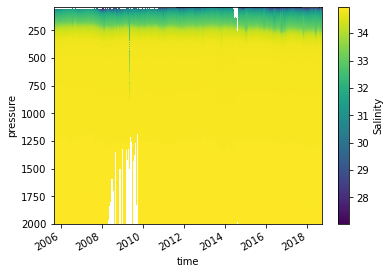

In [143]:
casts_D.Salinity.plot(y='pressure',yincrease=False)

In [157]:
time_index2 = pd.date_range(casts_D.time.values[0],casts_D.time.values[-1], freq="6H")

In [155]:
casts_D.time

<xarray.DataArray 'time' (time: 3968)>
array(['2005-08-30T06:00:00.000000000', '2005-08-30T12:00:00.000000000',
       '2005-08-31T12:00:00.000000000', ..., '2018-09-11T12:02:50.500982400',
       '2018-09-13T12:02:50.511523200', '2018-09-13T18:02:50.001072000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2005-08-30T06:00:00 ... 2018-09-13T18:02:50.001072

In [163]:
casts_D_reindex = casts_D.reindex({'time':time_index2},method='nearest',tolerance='5min')

In [129]:
import gsw

In [130]:
io.loadmat(filed[0])['location'][0].split(',')

['74 00.150 N', ' 139 58.926 W']

In [209]:
P,Time = np.meshgrid(casts_D.pressure.values,casts_D.time.values)

In [166]:
casts_D['SA'] = xr.DataArray(gsw.SA_from_SP(casts_D.Salinity.values,casts_D.pressure.values, 139.58,74)
                             ,dims={'time':casts_D.time.values,'pressure':casts_D.pressure.values})
casts_D['CT'] = xr.DataArray(gsw.CT_from_pt(casts_D.SA.values,casts_D.Potential_temperature.values)
                             ,dims={'time':casts_D.time.values,'pressure':casts_D.pressure.values})

In [167]:
casts_D.CT.values.shape


(3968, 982)

In [226]:
[Tu, Rsubrho, p_mid] = gsw.Turner_Rsubrho(casts_D.SA.values.T,casts_D.CT.values.T,P.T)

In [227]:
p_mid.shape

(981, 3968)

In [228]:
Tu = xr.DataArray(Tu,dims=['pressure','time']
                 , coords={'time':(['time'],casts_D.time),'pressure':(['pressure'],p_mid[:,0])})

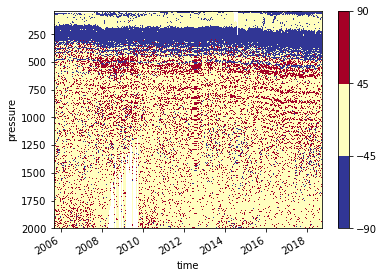

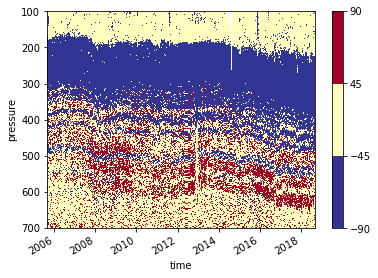

In [237]:
np.fmod(Tu,90).plot(y='pressure',levels=[-90,-45,45,90],cmap='RdYlBu_r',yincrease=False)
plt.figure()
np.fmod(Tu,90).sel(pressure=slice(100,700)).plot(y='pressure',levels=[-90,-45,45,90],cmap='RdYlBu_r',yincrease=False)

In [199]:
sal = casts_D['SA'].rolling(pressure=50, center=True).mean()
ct = casts_D['CT'].rolling(pressure=50, center=True).mean()

In [200]:
sal

<xarray.DataArray (time: 3968, pressure: 982)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * pressure  (pressure) float64 39.0 41.0 43.0 ... 1.999e+03 2.001e+03
  * time      (time) datetime64[ns] 2005-08-30T06:00:00 ... 2018-09-13T18:02:50.001072

In [230]:
[Tu_smooth, Rsubrho, p_mid] = gsw.Turner_Rsubrho(sal.values.T,ct.values.T,P.T)

In [231]:
Tu_smooth.shape

(981, 3968)

In [232]:
Tu_smooth = xr.DataArray(Tu_smooth,dims=['pressure','time'],
                  coords={'time':(['time'],casts_D.time),'pressure':(['pressure'],p_mid[:,0])})
Tu_smooth

<xarray.DataArray (pressure: 981, time: 3968)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * time      (time) datetime64[ns] 2005-08-30T06:00:00 ... 2018-09-13T18:02:50.001072
  * pressure  (pressure) float64 40.0 42.0 44.0 ... 1.996e+03 1.998e+03 2e+03

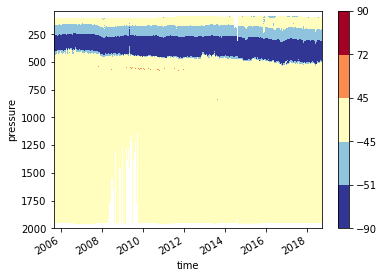

In [233]:
np.fmod(Tu_smooth,90).plot(y='pressure',levels=[-90,-51,-45,45,72,90],cmap='RdYlBu_r',yincrease=False)